<hr style="border:3px solid coral"></hr>

# Practice

<hr style="border:3px solid coral"></hr>

Goals for this notebook : 

* Learn about reading and writing binary data to easily transfer data between C and Python programs. 

<hr style="border:3px solid coral"></hr>

##  Reading and writing data between C and Python

<hr style="border:3px solid coral"></hr>

Once we start solving  interesting PDEs, we will want to be able to visualize the results.  To do this, we will use tools available in Python.  However, we need to be able to write data to a file from our C program, and then read it back into C.   More over, we want to be able to store "meta-data" as well (e.g. grid size, domain extent, etc). 

We will do this by creating binary files in C and read it back in in Python. 

## Example 1 : Writing data to a binary file

<hr style="border:3px solid black"></hr>


In [1]:
%%file magic_01.c

#include <stdio.h>
#include <stdlib.h>    // Needed for 'atoi' and 'exit(0)'

int main(int argc, char** argv)
{
    if (argc <= 1)
    {
        printf("Error : Include magic int at command line\n");
        exit(0);
    }
    int magic_int = atoi(argv[1]);  

    FILE *fout = fopen("magic_01.dat","w");        
    fwrite(&magic_int,sizeof(int),1, fout); 
    fclose(fout);

    return 0;
}

Overwriting magic_01.c


### Components 

<hr style="border:1px solid black"></hr>

    #include <stdio.h>
    #include <stdlib.h>    

The first header `stdio` is needed for the `printf`, and file IO operations `fopen`, `fwrite` and `fclose`. 

The second header is needed for `atoi` and `exit(0)`. 

<hr style="border:1px solid black"></hr>

    if (argc <= 1)
    {
        printf("Error : Supply a magic integer at command line\n");
        exit(0);
    }
    
This program will read a "magic number" from the command line.  We need to make sure that the user supplied a value at the command line. 

<hr style="border:1px solid black"></hr>

    int magic_int = atoi(argv[1]);  

Read the user-supplied magic integer from the command line arguments. 

<hr style="border:1px solid black"></hr>

    FILE *fout = fopen("magic_int.dat","w");        

We open a file with the name `magic_int.dat`.  The "w" indicates that we plan to *write* to the file.  The return is the *file handle* `fout`. 


<hr style="border:1px solid black"></hr>

    fwrite(&magic_int,sizeof(int),1,fout); 
    
This commands writes a specified number of entries from a memory location. 

* Address location is  `&magic_int`.

* The size of each entry is `sizeof(int)`  (4 bytes).  

* We write out 1 entry

* Write data to file with handle  `fout`. 
    
    
<hr style="border:1px solid black"></hr>

     fclose(fout);
     
Close the file when we are done. 

### Running the code

<hr style="border:1px solid black"></hr>


In [2]:
%%bash

rm -rf magic_01

gcc -o magic_01 magic_01.c

./magic_01  17

We can check that the file size is what we expect.  

In [3]:
import os

stats = os.stat("magic_01.dat")
print(f"File size : {stats.st_size:d} bytes")


File size : 4 bytes


### To do 

<hr style="border:2px solid black"></hr>

* Modify the code above to read in three magic numbers from the command line and write them to a data file. 

* Check that the file is the correct size

#### Note

* Use a *single* `fwrite` statement. 

In [4]:
%%file magic_02.c

#include <stdio.h>     // Needed for file IO
#include <stdlib.h>    // Needed for 'atoi' and 'exit(0)'

int main(int argc, char** argv)
{
    if (argc < 4)
    {
        printf("Error : Include three magic ints at command line\n");
        exit(0);
    }
    int magic_int[3];
    
    for(int i = 0; i < 4; i++)
    {
        printf("%s\n",argv[i]);
    }

    for(int i = 0; i < 3; i++)
    {
        magic_int[i] = atoi(argv[i+1]);          
    }
    
    FILE *fout = fopen("magic_02.dat","w");   
    fwrite(&magic_int[0],sizeof(int),3, fout); 
    fclose(fout);

    return 0;
}

Overwriting magic_02.c


In [5]:
%%bash

rm -rf magic_02

gcc -o magic_02 magic_02.c

./magic_02 17 13 21

./magic_02
17
13
21


In [6]:
import os

stats = os.stat("magic_02.dat")
print(f"File size : {stats.st_size:d} bytes")

File size : 12 bytes


In [7]:
%cat magic_02.dat

      


### Example 2 : Reading data in Python

<hr style="border:3px solid black"></hr>

We can read the the data back into Python by first describing a data type, and then reading the data using the  template described by the data type. 

* The Numpy `dtype` can be used to create a list of tuples describing the data type.  This will be particularly useful for files containing mixed data types. 

You can read more about Numpy `dtype` [here](https://numpy.org/doc/stable/reference/generated/numpy.dtype.html).

In [8]:
import numpy as np
from numpy import *

dt = np.dtype([('magic_int',(np.int32,3))])
dt

dtype([('magic_int', '<i4', (3,))])

In [9]:
fout = open("magic_02.dat","rb")
d = np.fromfile(fout,dtype=dt, count=1)
fout.close()

display(d[0][0])

array([17, 13, 21], dtype=int32)

#### Question

* How does the return variable `d` store entries from the file? 

### To do

* Modify the above to read in three integers from `magic_02.dat`.  

### Example 2 : Reading and writing mixed-type data

<hr style="border:3px solid black"></hr>

Often, we want to store data, along with some "meta data".  

Consider the following example that generates a mesh of values $f_{i} = f(x_i)$ for a specified function $f(x)$. 

In [25]:
%%file array_01.c

#include <stdio.h>
#include <stdlib.h>
#include <math.h>

double* allocate_1d(int n)
{
    double *mem = (double*) malloc(n*sizeof(double));
    double *y = &mem[0];
    return y;
}

double  f(double x)
{
    return cos(M_PI*x);
}

int main(int argv, char** argc)
{
    int N = 128;
    
    double a = 0; 
    double b = 1; 
    
    double *x = allocate_1d(N+1);
    double *fx = allocate_1d(N+1);

    double h = (b-a)/N;
    
    for(int i = 0; i < N+1; i++)
    {
        x[i] = a + h*i;
        fx[i] = f(x[i]);
    }
    
    FILE *fout = fopen("array_01.dat","w");   
    fwrite(&N,sizeof(int),1, fout); 
    fwrite(&a,sizeof(double),1, fout); 
    fwrite(&b,sizeof(double),1, fout); 
    fwrite(&x[0],sizeof(double),N+1, fout); 
    fwrite(&fx[0],sizeof(double),N+1, fout);     
    fclose(fout);    
    
}

Overwriting array_01.c


In [26]:
%%bash

rm -rf array_01

gcc -o array_01 array_01.c

./array_01

In [27]:
import os

stats = os.stat("array_01.dat")
print(f"File size : {stats.st_size:d} bytes")

N = 128
print("Expected file size : ",2*(N+1)*8 + 2*8 + 4)

File size : 2084 bytes
Expected file size :  2084


### To Do

* Add statements that writes out array data $x_i$ and $f_i$ along with metadata $N$, interval data $[a,b]$. 

* Load the data into Python and plot the function $f(x)$. 

* Plot the results in Python and compare to the true function $f(x)$. 

### Tips

* Create a Numpy `dtype` to read data into Python. 

In [28]:
from matplotlib.pyplot import *
from numpy import *

In [32]:
# fout = open('array_01.dat','rb')
# N = fromfile(fout,dtype=int32,count=1)[0]
# fout.close()
# print(N)

# Create a Numpy dtype
dt = dtype([('N',np.int32), \
            ('a',np.float64),\
            ('b',np.float64),\
            ('x',(np.float64,N+1)), \
            ('fx',(np.float64,N+1))])

# read data from file
fout = open('array_01.dat','rb')
N,a,b,x,fx = fromfile(fout,dtype=dt,count=1)[0]
fout.close()

In [33]:
x

array([0.       , 0.0078125, 0.015625 , 0.0234375, 0.03125  , 0.0390625,
       0.046875 , 0.0546875, 0.0625   , 0.0703125, 0.078125 , 0.0859375,
       0.09375  , 0.1015625, 0.109375 , 0.1171875, 0.125    , 0.1328125,
       0.140625 , 0.1484375, 0.15625  , 0.1640625, 0.171875 , 0.1796875,
       0.1875   , 0.1953125, 0.203125 , 0.2109375, 0.21875  , 0.2265625,
       0.234375 , 0.2421875, 0.25     , 0.2578125, 0.265625 , 0.2734375,
       0.28125  , 0.2890625, 0.296875 , 0.3046875, 0.3125   , 0.3203125,
       0.328125 , 0.3359375, 0.34375  , 0.3515625, 0.359375 , 0.3671875,
       0.375    , 0.3828125, 0.390625 , 0.3984375, 0.40625  , 0.4140625,
       0.421875 , 0.4296875, 0.4375   , 0.4453125, 0.453125 , 0.4609375,
       0.46875  , 0.4765625, 0.484375 , 0.4921875, 0.5      , 0.5078125,
       0.515625 , 0.5234375, 0.53125  , 0.5390625, 0.546875 , 0.5546875,
       0.5625   , 0.5703125, 0.578125 , 0.5859375, 0.59375  , 0.6015625,
       0.609375 , 0.6171875, 0.625    , 0.6328125, 

0.0

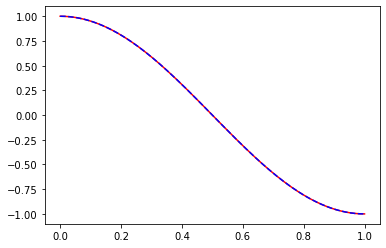

In [30]:
# Plot results here

figure(1)
clf()

plot(x,fx,'r');

# Compare to true solution
plot(x,cos(pi*x),'b--');
max(abs(fx-cos(pi*x)))

### Example 3 : Two dimensional arrays in C

<hr style="border:2px solid black"></hr>

Statically defined 2d arrays in C can be allocated as follows: 

     int N = 64;
     double fxy[N+1][N+1];
     
Then, we can access the entries in `fxy` as `fxy[i][j]`.  

* When allocating "automatic" arrays, we don't need to worry about de-allocation. 

### To Do

* Modify the code below to create a grid of values for the function $f(x,y) = \cos(\pi x)\sin(\pi y)$ on the domain $[-1,1] \times [-1,1]$.    

* Write out the data, along with any useful metadata. 

* Read the results back into Python, and plot the results using `imshow`. 

### Tips

* The memory represented by `fx[N+1][N+1]` is a *contiguous* block of memory.  This means that you can write out the memory as a single $(N+1)^2$ 1d array.

* Use the Numpy `reshape` function to reshape the 1d data into a 2d array for plotting

* 

In [20]:
%%file array_02.c

#include <stdio.h>
#include <stdlib.h>
#include <math.h>

double* allocate_1d(int n)
{
    double *mem = (double*) malloc(n*sizeof(double));
    return &mem[0];
}

void free_1d(double **y)
{
    free(*y);
    *y = NULL;
}

double  f(double x)
{
    return cos(x);
}

int main(int argv, char** argc)
{
    int N = 64;
    
    double a = 0; 
    double b = 1; 
    
    double *x = allocate_1d(N+1);    
    double *y = allocate_1d(N+1);

    double h = (b-a)/N;
    
    for(int i = 0; i < N+1; i++)
    {
        x[i] = a + h*i;
        y[i] = f(x[i]);
    }
    
    double fxy[N+1][N+1];
    
    /* Assign valuels to f(x,y) using a double loop */
    
    
    /* Add statements to write out data x, y and metadata N, a and b.  */
    
    free_1d(&x);
    free_1d(&y);
}

Overwriting array_02.c


In [21]:
%%bash

rm -rf array_02

gcc -o array_02 array_02.c

./array_02

In [22]:
# Load data here

In [24]:
# Plot data here

clf()
figure(3)


e = [x[0],x[N],y[0],y[N]]
imshow(fxy,cmap=cm.Greys,aspect=True,extent=e,origin="lower");


NameError: name 'y' is not defined

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>